# Econometric Forecasts


_UNDER CONSTRUCTION_


- Trends: seasonality
- Autocorrelation Function: AR, MA, SARIMAX
- Unit root: integration order
- Forecasting: single-step, multi-step
- Granger casuality, impulse response function, Vector Autoregression


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns 
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error        
from finds.readers import Alfred
from finds.busday import BusDay
from finds.econs import integration_order
from finds.misc import Show
from secret import paths, credentials
show = Show(ndigits=4, latex=None)
VERBOSE = 0
# %matplotlib qt

In [2]:
imgdir = paths['images'] / 'ts'
alf = Alfred(api_key=credentials['fred']['api_key'])

In [3]:
series_id, freq, start = 'CPIAUCNS', 'M', 0 #19620101  # not seasonally adjusted

df = alf(series_id, log=1, freq=freq, start=start).dropna()
df.index = BusDay.to_datetime(df.index)

## Seasonality

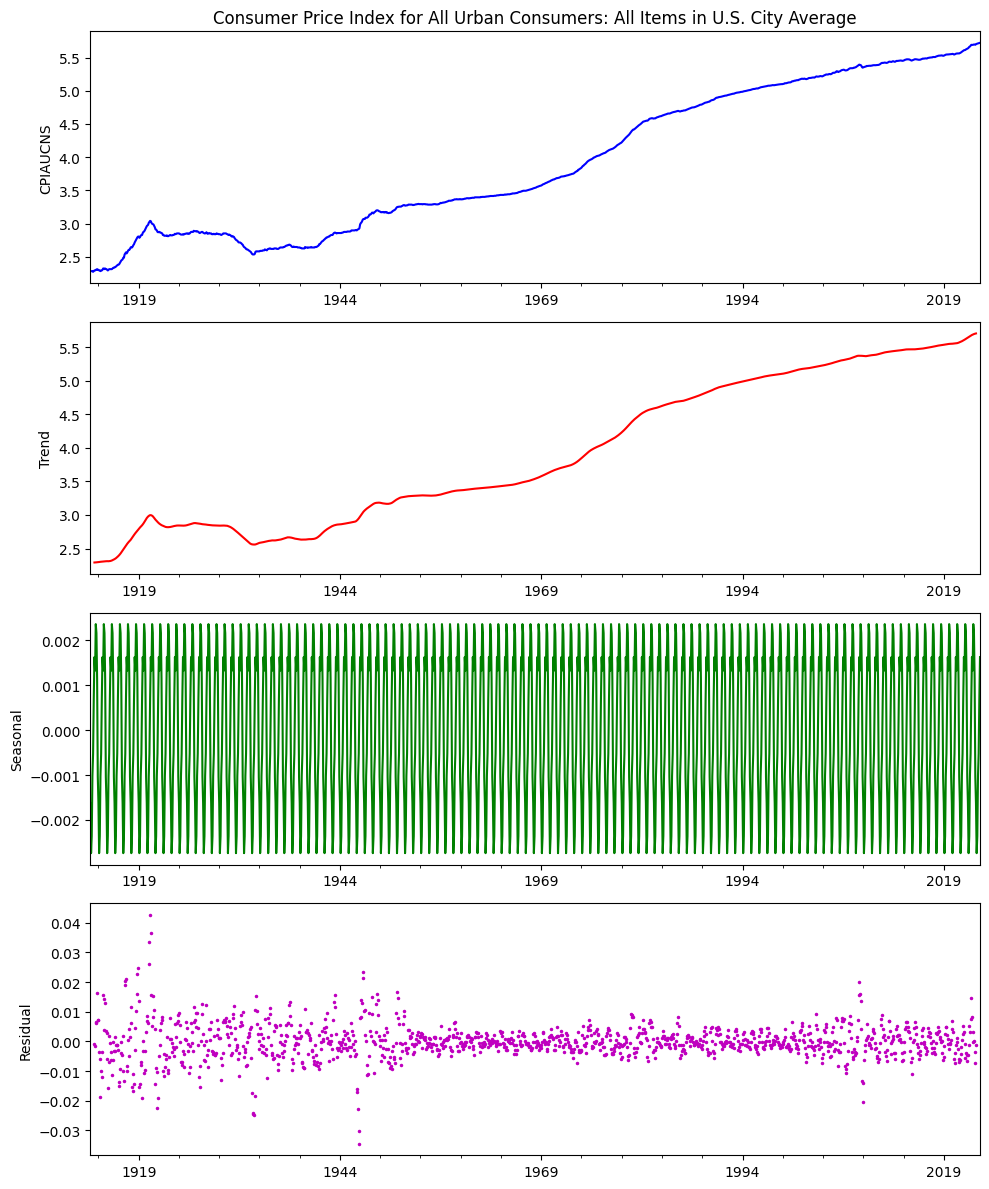

In [4]:
## Seasonality Decomposition Plot
result = seasonal_decompose(df, model = 'add')
fig, ax = plt.subplots(nrows=4, ncols=1, clear=True, figsize=(10, 12))
result.observed.plot(ax=ax[0], title=alf.header(result.observed.name),
                     ylabel=result.observed.name, xlabel='', c='b')
result.trend.plot(ax=ax[1], ylabel='Trend', xlabel='', c='r')
result.seasonal.plot(ax=ax[2], ylabel='Seasonal', xlabel='', c='g')
result.resid.plot(ax=ax[3], ls='', ms=3, marker='.', c='m',
                  ylabel='Residual', xlabel='')
plt.tight_layout()
plt.savefig(imgdir / 'seasonal.jpg')

## Autocorrelation 
Plot ACF and PACF

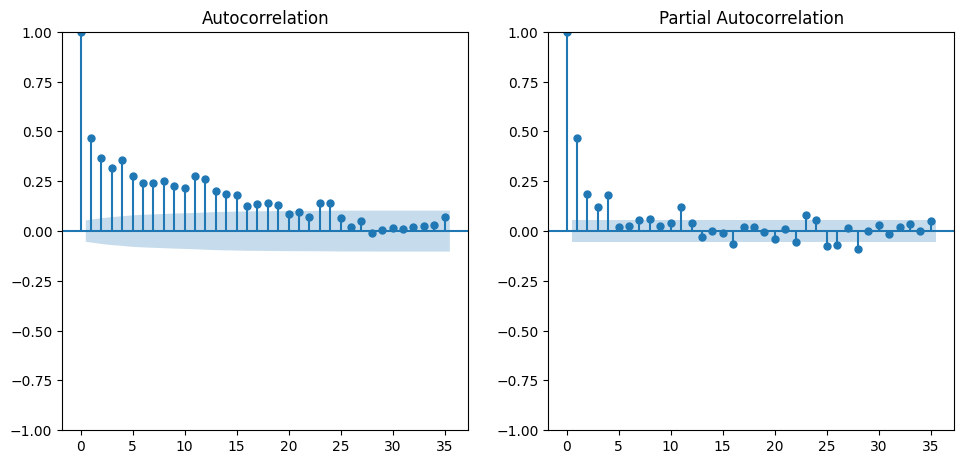

In [5]:
values = df.diff().dropna().values.squeeze()
fig, axes = plt.subplots(1, 2, clear=True, figsize=(10,5))
plot_acf(values, lags=35, ax=axes[0])
plot_pacf(values, lags=35, ax=axes[1], method='ywm')
plt.tight_layout(pad=2)
plt.savefig(imgdir / 'acf.jpg')

## Stationarity

Integration Order: Log CPI (Seasonally Adjusted)

In [6]:
series_id = 'CPIAUCSL' #19620101  # seasonally adjusted
#series_id = 'GDPC1'
df = alf(series_id, log=1, start=0).dropna()
df.index = BusDay.to_datetime(df.index)
p = integration_order(df, noprint=False, pvalue=0.05)
Series({series_id: p}, name='I(p)').to_frame()

Augmented Dickey-Fuller unit root test:
      Test Statistic   p-value  Lags Used  Obs Used  Critical Value (1%)  Critical Value (5%)  Critical Value (10%)
I(0)       -0.154936  0.943684       15.0     903.0            -3.437612            -2.864746             -2.568477
      Test Statistic   p-value  Lags Used  Obs Used  Critical Value (1%)  Critical Value (5%)  Critical Value (10%)
I(1)       -4.575503  0.000143       14.0     903.0            -3.437612            -2.864746             -2.568477


,I(p)
CPIAUCSL,1


Histogram Plot and Kernel Density Estimate

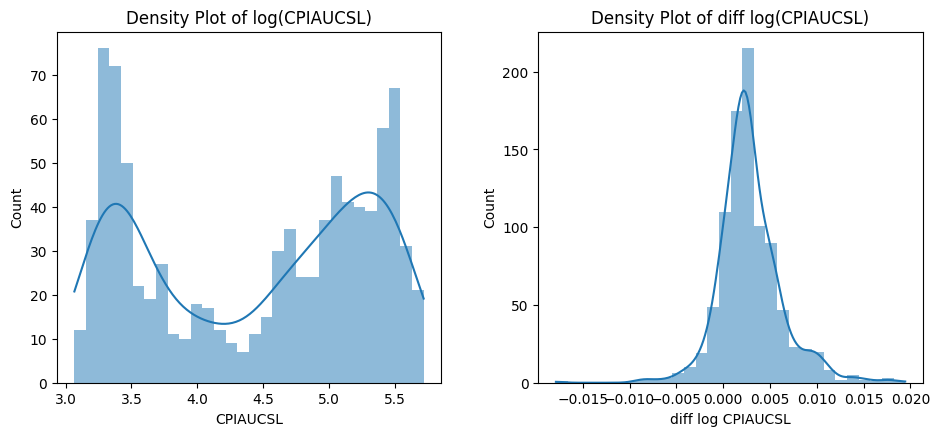

In [7]:
fig, axes = plt.subplots(1, 2, clear=True, figsize=(10,5))
sns.histplot(df.dropna(),
             bins=30,
             lw=0,
             kde=True,
             #line_kws={"color": "r"},
             ax=axes[0])
axes[0].set_title(f"Density Plot of log({series_id})")
sns.histplot(df.diff().dropna().rename(f"diff log {series_id}"),
             bins=30,
             lw=0,
             kde=True,
             #line_kws={"color": "r"},
             ax=axes[1])
axes[1].set_title(f"Density Plot of diff log({series_id})")
plt.savefig(imgdir / 'order.jpg')
plt.tight_layout(pad=3)

## AR, ARMA, SARIMAX
- AR(p) is simplest time-model, can nest in SARIMAX(p,d,q,s) with
- integration order I(d), moving average MA(q), seasonality S(s), exogenous X

In [8]:
split_date = '2021-12-31'
series_id, freq, start = 'CPIAUCNS', 'M', 0  # not seasonally adjust
log_df = alf(series_id, log=1)
log_df.index = BusDay.to_datetime(log_df.index)
log_df = log_df.loc[:split_date].dropna()

/home/terence/env3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/terence/env3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.76541D+00    |proj g|=  1.11379D+02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f= -3.78602D+00    |proj g|=  2.76533D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     26      1     0     0   2.765D-01  -3.786D+00
  F =  -3.7860213397202140     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               CPIAUCNS   No. Observations:                 1308
Model:               SARIMAX(1, 1, 3)   Log Likelihood                4952.116
Date:                Thu, 31 Aug 2023   AIC                          -9892.232
Time:                        06:58:58   BIC                          -9861.179
Sample:                    01-31-1913   HQIC                         -9880.584
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004   9.68e-05      3.688      0.000       0.000       0.001
ar.L1          0.8589      0.030     28.855      0.000       0.801       0.917
ma.L1         -0.5255      0.032    -16.528      0.000      -0.588      -0.463
ma.L2         -0.0763      0.025     -3.032      0.002      -0.126      -0.027
ma.L3         -0.0576      0.023     -2.479      0.013      -0.103      -0.012
sigma2      2.994e-05   4.82e-07     62.116      0.000     2.9e-05    3.09e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              7896.60
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

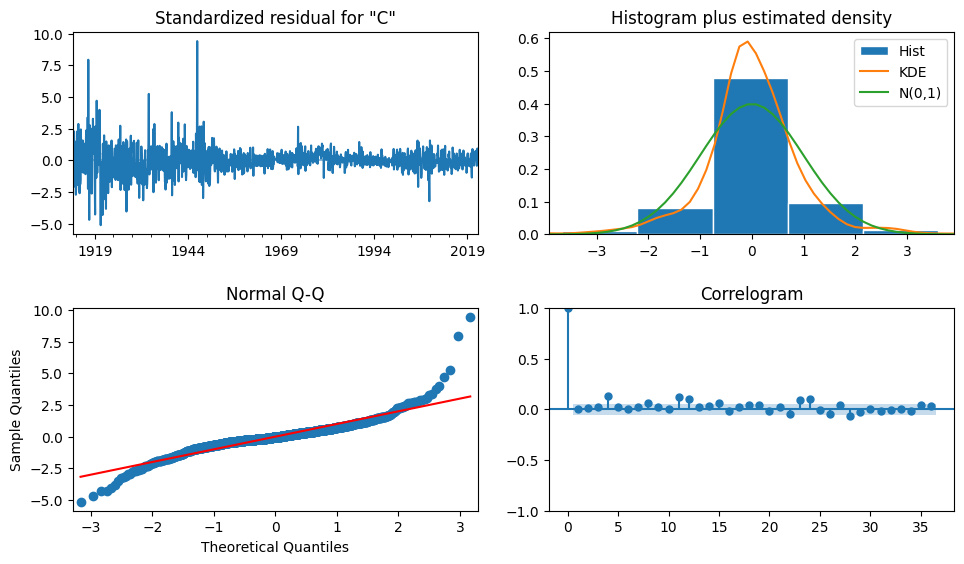

In [9]:
pdq = (1, 1, 3)   #(12, 1, 0)
seasonal_pdqs = (0, 0, 0, 12)
arima = SARIMAX(log_df,
                order=pdq,
                seasonal_order=seasonal_pdqs,
                trend='c').fit()
fig = arima.plot_diagnostics(figsize=(10,6), lags=36)
plt.tight_layout(pad=2)
plt.savefig(imgdir / 'ar.jpg')
arima.summary()

## Forecasting

In [10]:
series_id, start = 'CPIAUCSL', 0
df = alf(series_id, log=1, diff=1, start=start).dropna()
df.index = BusDay.to_datetime(df.index)
df_train = df[df.index <= split_date]
df_test = df[df.index > split_date]

In [11]:
## Select AR lag order
"""ARMA select order is too slow and unstable in statsmodels
# Select ARMA lag order
from statsmodels.tsa.stattools import arma_order_select_ic
series_id = 'CPIAUCSL'
df = alf(series_id, log=1, diff=1).dropna()
df.index = BusDay.to_datetime(df.index)
split_date = '2021-06-30'
df_train = df[df.index <= split_date]
df_test = df[df.index > split_date]
res = arma_order_select_ic(df_train,
                           max_ar=36,
                           max_ma=12,
                           ic='aic',
                           trend='n')
print('(p, q) = ', res.aic_min_order)
"""

"ARMA select order is too slow and unstable in statsmodels\n# Select ARMA lag order\nfrom statsmodels.tsa.stattools import arma_order_select_ic\nseries_id = 'CPIAUCSL'\ndf = alf(series_id, log=1, diff=1).dropna()\ndf.index = BusDay.to_datetime(df.index)\nsplit_date = '2021-06-30'\ndf_train = df[df.index <= split_date]\ndf_test = df[df.index > split_date]\nres = arma_order_select_ic(df_train,\n                           max_ar=36,\n                           max_ma=12,\n                           ic='aic',\n                           trend='n')\nprint('(p, q) = ', res.aic_min_order)\n"

In [12]:
lags = ar_select_order(df_train,
                       maxlag=36,
                       ic='bic',
                       old_names=False).ar_lags
print('(BIC) lags= ', len(lags), ':', lags)

(BIC) lags=  12 : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


/home/terence/env3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/terence/env3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


__One-step ahead predictions__


In [13]:
model = AutoReg(df_train, lags=lags, old_names=False).fit()  
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:               CPIAUCSL   No. Observations:                  899
Model:                    AutoReg(12)   Log Likelihood                4064.408
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Thu, 31 Aug 2023   AIC                          -8100.815
Time:                        06:58:58   BIC                          -8033.785
Sample:                    02-29-1948   HQIC                         -8075.191
                         - 12-31-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0005      0.000      4.000      0.000       0.000       0.001
CPIAUCSL.L1      0.4431      0.033     13.433      0.000       0.378       0.508
CPIAUCSL.L2      0.0451      0.036      1.25

/home/terence/env3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [14]:
### Observations to predict are from the test split
all_dates = AutoReg(df, lags=lags, old_names=False)

/home/terence/env3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [15]:
### Use model params from train split, start predictions from last train row    
df_pred = all_dates.predict(model.params,
                            start=df_train.index[-1]).shift(1).iloc[1:]
mse = mean_squared_error(df_test, df_pred)
var = np.mean(np.square(df_test - df_train.mean()))
print(f"ST Forecast({len(df_pred)}): rmse={np.sqrt(mse)} r2={1-mse/var}")

ST Forecast(19): rmse=0.003233725982906748 r2=0.1608176217788846


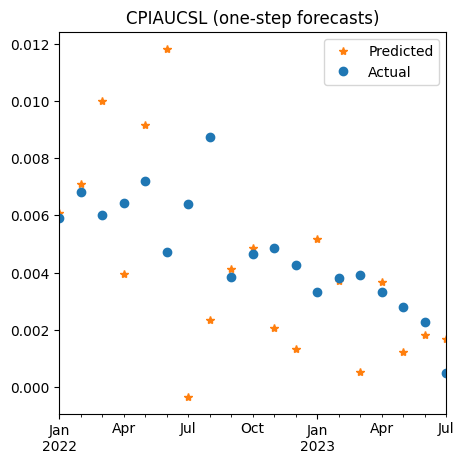

In [16]:
fig, ax = plt.subplots(clear=True, num=1, figsize=(5, 5))
df_test.plot(ax=ax, c='C1', ls='', marker='*')
df_pred.plot(ax=ax, c='C0', ls='', marker='o')
ax.legend(['Predicted', 'Actual'])
ax.set_title(series_id + " (one-step forecasts)")
ax.set_xlabel('')
plt.tight_layout(pad=2)
plt.savefig(imgdir / 'short.jpg')

__Multi-step ahead predictions__


Long-term Forecasts:  rmse=0.002876 r2=0.3363


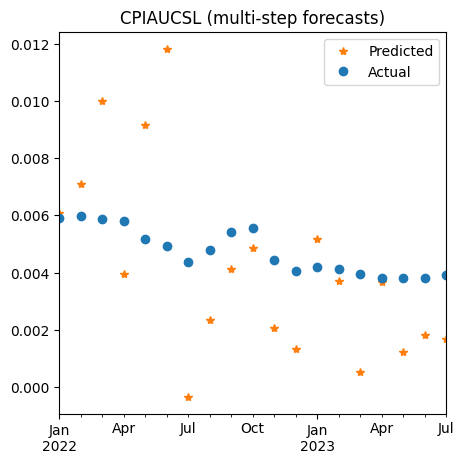

In [17]:
df_pred = all_dates.predict(model.params,
                            start=df_train.index[-1],
                            end=df_test.index[-1],
                            dynamic=0).shift(1).iloc[1:]
mse = mean_squared_error(df_test, df_pred)
var = np.mean(np.square(df_test - df_train.mean()))
print(f"Long-term Forecasts:  rmse={np.sqrt(mse):.6f} r2={1-mse/var:.4f}")
fig, ax = plt.subplots(clear=True, num=2, figsize=(5, 5))
df_test.plot(ax=ax, c='C1', ls='', marker='*')
df_pred.plot(ax=ax, c='C0', ls='', marker='o')
ax.legend(['Predicted', 'Actual'])
ax.set_title(series_id + " (multi-step forecasts)")
ax.set_xlabel('')
plt.tight_layout(pad=2)
plt.savefig(imgdir / 'long.jpg')

## Granger Causality

In [18]:
# Granger Causality: INDPRO vs CPI
variables = ['CPIAUCSL', 'INDPRO']
#variables = ['CPIAUCSL', 'WPSFD4131']
start = 19620101
for series_id, exog_id in zip(variables, list(reversed(variables))):
    df = pd.concat([alf(s, start=start, log=1)
                    for s in [series_id, exog_id]], axis=1)
    df.index = pd.DatetimeIndex(df.index.astype(str))
    data = df.diff().dropna()

    print(f"Null Hypothesis: {exog_id} granger-causes {series_id}")
    res = grangercausalitytests(data, 3)
    print()

    dmf = (f'{series_id} ~ {series_id}.shift(1) '
           f' + {exog_id}.shift(1) '
           f' + {exog_id}.shift(2) '
           f' + {exog_id}.shift(3) ')
#           f' + {exog_id}.shift(4) ')
    model = smf.ols(formula=dmf, data=data).fit()
    robust = model.get_robustcov_results(cov_type='HAC', use_t=None, maxlags=0)
    print(robust.summary())

Null Hypothesis: INDPRO granger-causes CPIAUCSL

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0229  , p=0.8797  , df_denom=734, df_num=1
ssr based chi2 test:   chi2=0.0230  , p=0.8795  , df=1
likelihood ratio test: chi2=0.0230  , p=0.8795  , df=1
parameter F test:         F=0.0229  , p=0.8797  , df_denom=734, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0166  , p=0.9835  , df_denom=731, df_num=2
ssr based chi2 test:   chi2=0.0335  , p=0.9834  , df=2
likelihood ratio test: chi2=0.0335  , p=0.9834  , df=2
parameter F test:         F=0.0166  , p=0.9835  , df_denom=731, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0969  , p=0.9618  , df_denom=728, df_num=3
ssr based chi2 test:   chi2=0.2934  , p=0.9613  , df=3
likelihood ratio test: chi2=0.2933  , p=0.9613  , df=3
parameter F test:         F=0.0969  , p=0.9618  , df_denom=728, df_num=3

                            OLS Regression Re

## Vector Autoregression

- Impulse Response Function

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, Aug, 2023
Time:                     06:59:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -21.3075
Nobs:                     735.000    HQIC:                  -21.3614
Log likelihood:           5790.88    FPE:                5.10743e-10
AIC:                     -21.3952    Det(Omega_mle):     5.01152e-10
--------------------------------------------------------------------
Results for equation INDPRO
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001959         0.000530            3.697           0.000
L1.INDPRO           0.268216         0.037126            7.225           0.000
L1.CPIAUCSL         0.410245         0.138383            2.965     

/home/terence/env3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


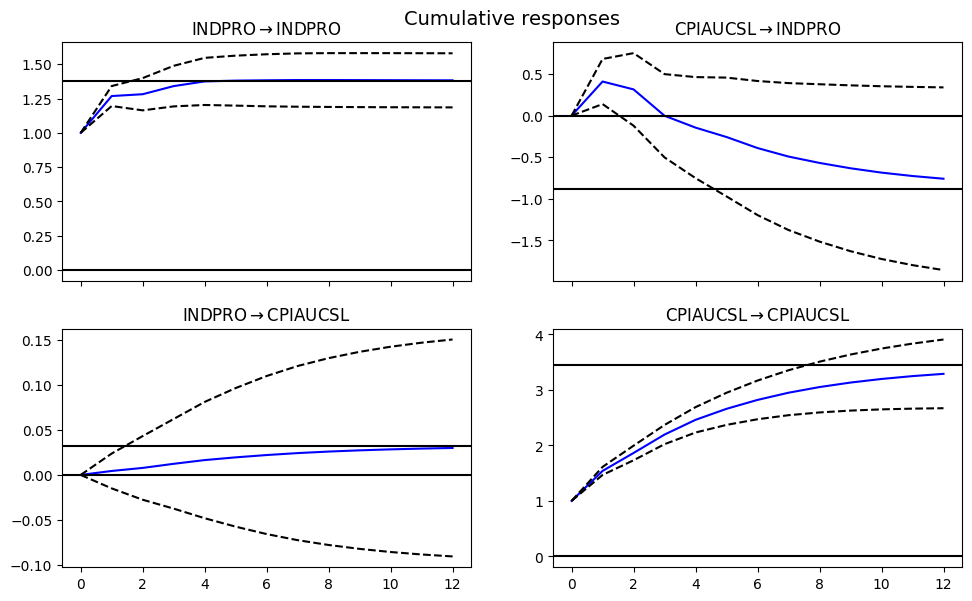

In [19]:
# Vector Autoregression: Impulse Response Function
model = VAR(data)
results = model.fit(3)
print(results.summary())
irf = results.irf(12)
#irf.plot(orth=False)
irf.plot_cum_effects(orth=False, figsize=(10, 6))
plt.savefig(imgdir / 'impulse.jpg')